In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, wget, shutil

# Notebook overview

## Differential Privacy and Privacy Protection
Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject carefully calibrated random noise into computations, such as LOO mean, making it mathematically difficult to isolate individual contributions. 

In this section we show how DP can be applied to data. This example revolves around anonymizing a dataset of individual heights that contains significant outliers. 

## The goal

The goal is to protect the data without compromising the privacy of any individual, especially in high risk or adversarial environments.

Down below we use usecase-2.1 individual's height.


In [2]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,delim_whitespace="\t")["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]


100% [..........................................................] 39886 / 39886
Original file downloaded.


## User Output

A data user on the SIESTA platform is typically a researcher from an institution, aiming to answer a scientific question using sensitive data. Since the original data cannot be downloaded directly due to privacy concerns, the data user must develop their analysis pipeline using an anonymized dataset that mimics the structure of the real data. Once developed, the analysis is containerized, where this containerized pipeline is then executed by the platform operator on the original data. 

After applying **differential privacy** techniques on the results, it will be shared back with the data user. If the result is injected with noise before releasing it, for example, by adding Laplace noise proportional to the L1 sensitivity of the mean. The attacker cannot recover the true values exactly, because the values are altered with noise. 

We implement a DP mechanism by adding Laplace noise scaled by sensitivity, defined here as the maximum deviation between the true mean and the leave-one-out estimates.


In [35]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

def dp(clean_data,pipeline_output):

    user_output_variable = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    
    loo_mean = np.mean(user_output_variable)
    loo_scale = np.std(user_output_variable)
    sensitivity = np.max(np.abs(loo_mean - pipeline_output)) 

    while True:
        noise = np.random.laplace(loc=0.0, scale=np.median(loo_scale))
        if abs(noise) >= sensitivity:
            break
        
    return pipeline_output + noise

pipeline_output = user_output(clean_data)
print(f"dp: {dp(clean_data,pipeline_output)}, pipeline_output: {pipeline_output}")

dp: 162.86345814187686, pipeline_output: 163.42499999999998


## Simulation
Here we simulate a potential privacy attack scenario where an adversary attempts to reconstruct the original individual data values from noisy LOO means.

To protect privacy, Laplace noise is added to the LOO means using the DP mechanism. However, even after adding noise, it's important to evaluate how well the attacker could still reconstruct the original values. 

The DP mechanism is randomized, each execution adds different noise. So, we run a Monte Carlo (MC) simulation 1000 times to:

- Simulate many possible outcomes of the noisy LOO release.
- Perform reconstruction attempts based on each noisy release.
- Visualize the distribution of attacker guesses for each individual’s value.

This allows us to:

- Understand the variability in the reconstructions.
- Check whether the true values are consistently hidden within a wide distribution.
- Provide empirical evidence that the data remains private on average, even if some reconstructions appear close by chance.

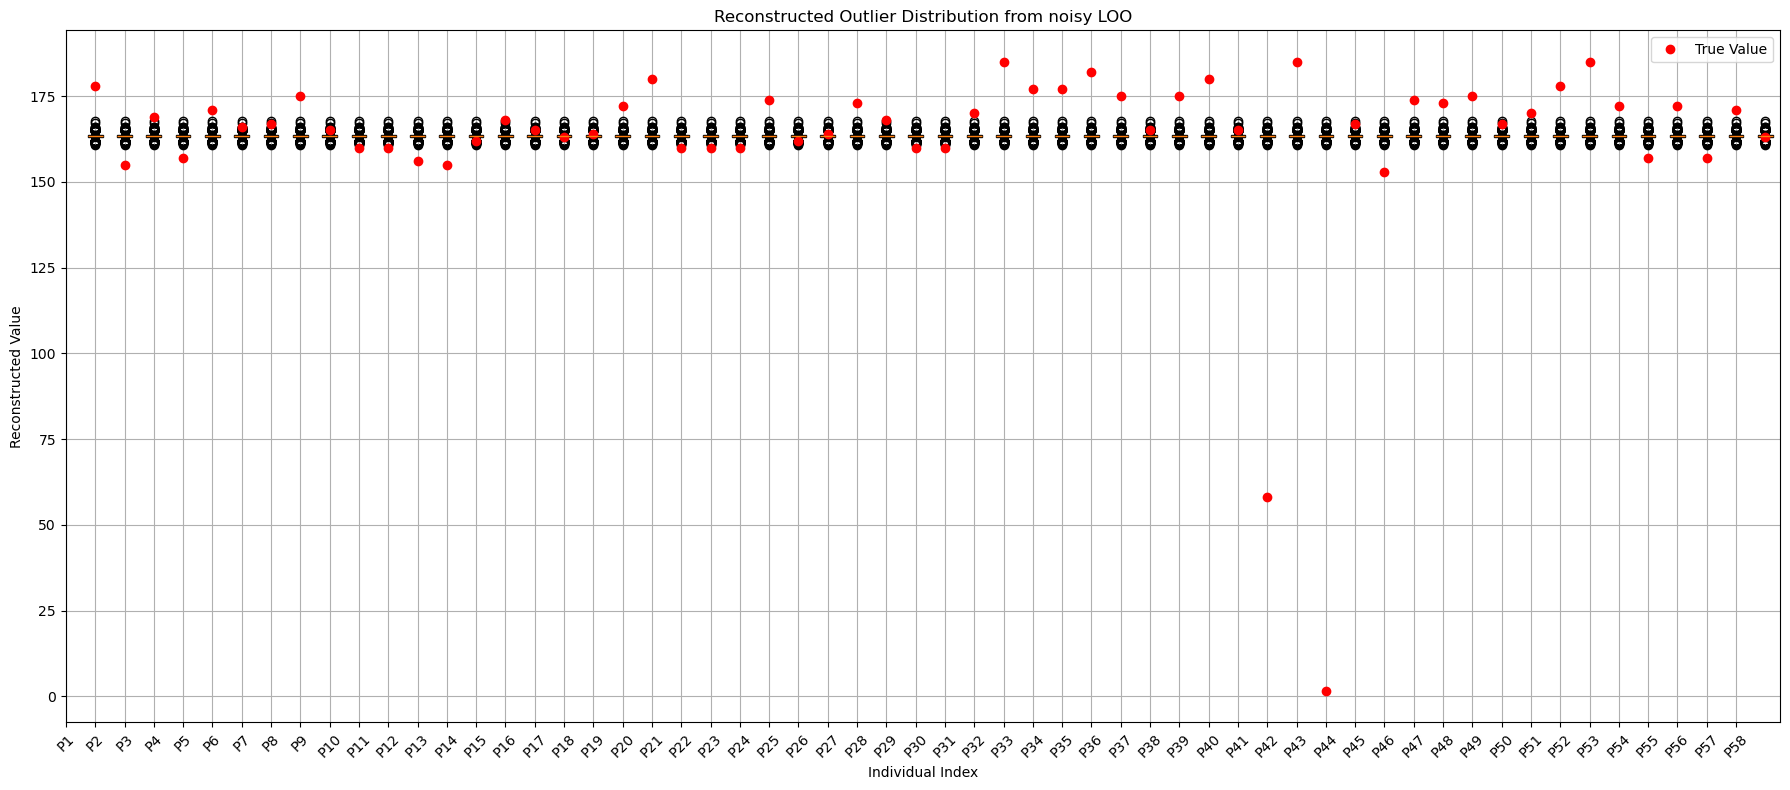

In [39]:
MC = 1000
n = len(clean_data)
rec = np.zeros((MC, n))  

for i in range(MC):
    pipeline_output = user_output(clean_data)
    noisy_user_output = dp(clean_data,pipeline_output)
    rec[i] = noisy_user_output

plt.figure(figsize=(18, 8))
plt.boxplot(rec, labels=[f"Person {i+1}" for i in range(n)], patch_artist=True)
plt.plot(range(1, n+1), clean_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Individual Index")
indices = np.arange(len(clean_data))
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
